In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#export
from exp.nb_05 import *

[Jump_to notebook introduction in lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3167)

# 1. Early stopping

### Better callback cancellation

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3230)

In [5]:
# get the data, set the loss function
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
n_hidden,batch_size = 50,512
n_out = y_train.max().item()+1
loss_func = F.cross_entropy

In [6]:
# create a DataBunch
data = DataBunch(*get_dls(train_ds, valid_ds, batch_size), n_out)

In [7]:
#export

# Callback() class is slightly refactored from notebook 04_callbacks
class Callback():
    
    # initialize _order to zero. 
    _order=0
    
    # set_runner() method takes a callback as an input
    #     note that initially self.run is unset -- there is no default value 
    def set_runner(self, run): 
        self.run=run
    def __getattr__(self, callback_name): 
        return getattr(self.run, callback_name)
    
    # set the callback name property
    #     if the callback doesn't have a name, set the callback name property to 'callback'
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    # this is the only modification to the 04_callbacks notebook
    #     it allows the Callback() class to be called as a function
    def __call__(self, callback_name):
        f = getattr(self, callback_name, None)
        # check this callback name, and return True if it is the requested callback
        if f and f(): return True
        return False

# this helper callback is used in Runner()
class TrainEvalCallback(Callback):
    
    # initialize the epoch, batch, and iteration counters
    def begin_fit(self):
        self.run.n_epoch_float=0.
        self.run.n_batch = 0
        self.run.n_iter=0
    
    # if we are in the training phase, update the epoch and batch counters
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epoch_float += 1./self.n_samples
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        # each batch represents a fraction of an epoch
        self.run.n_epoch_float=self.n_epoch_float
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

# add three cancellation callbacks
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [23]:
#export
class Runner():

    # initialize by setting the stop Flag to False, and constructing a list of callbacks from the inputs
    def __init__(self, callbacks=None, callback_funcs=None):
        # inputs are two lists: callbacks and callback_funcs
        # Q: it's not clear why we need two lists rather than one
        # create a list of callbacks from the input callbacks
        callbacks = listify(callbacks)
        # associate each callback_func() to its snake case callback name then append it to the callbacks list
        for callback_func in listify(callback_funcs):
            callback = callback_func()
            setattr(self, callback.name, callback)
            callbacks.append(callback)
        # set the stopping flag to `False` and append TrainEvalCallback() to the callbacks list
        self.stop,self.callbacks = False,[TrainEvalCallback()]+callbacks

    # get the properties of the Learner object
    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data
    
    
    # method to process a single batch
    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    # method to process all batches
    def all_batches(self, dataloader):
        # total number of batches in an epoch
        self.n_batches = len(dataloader)
        try:
            for xb,yb in dataloader: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            # set the `after_fit` state to `True`
            self('after_fit')
            # erase the Learner object
            self.learn = None

    def __call__(self, callback_name):
        # __call__ allows an instance of this class to be called as a function
        # Q: note clear what this loop is trying to do; it always returns result = False
        result = False
        for callback in sorted(self.callbacks, key=lambda x: x._order): 
            result = callback(callback_name) and result
        return result

In [24]:
learn = create_learner(get_model, loss_func, data)

In [25]:
class TestCallback(Callback):
    _order=1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter>=10: raise CancelTrainException()

In [26]:
run = Runner(cb_funcs=TestCallback)

In [27]:
run.fit(3, learn)

0
1
2
3
4
5
6
7
8
9
10


# 2. AvgStatsCallback, Recorder, and ParamScheduler Callbacks

In [42]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,in_train = True),AvgStats(metrics,in_train = False)
        
    # initialize train_stats and valid_stats
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    # compute and accumulate stats after the loss function has been evaluated
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    # print stats after the epoch has been processed
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): 
        plt.plot(self.lrs[pgid])
        plt.xlabel('iteration')
        plt.ylabel('loss')
    def plot_loss(self, skip_last=0): # !!!!! not used
        plt.plot(self.losses[:len(self.losses)-skip_last])
        plt.xlabel('iteration')
        plt.ylabel('loss')

        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])
        plt.xlabel('learning rate')
        plt.ylabel('loss')

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): 
        self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

# 3. Learning Rate Finder

NB: You may want to also add something that saves the model before running this, and loads it back after running - otherwise you'll lose your weights!

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3545)

In [43]:
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

NB: In fastai we also use exponential smoothing on the loss. For that reason we check for `best_loss*3` instead of `best_loss*10`.

In [44]:
learn = create_learner(get_model, loss_func, data)

In [45]:
run = Runner(cb_funcs=[LR_Find, Recorder])

In [46]:
run.fit(2, learn)

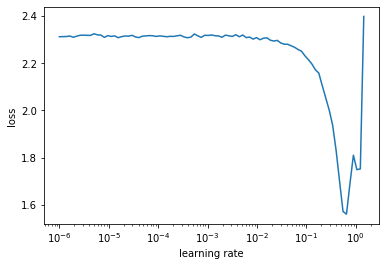

In [47]:
run.recorder.plot(skip_last=5)

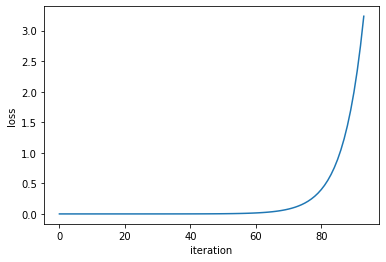

In [48]:
run.recorder.plot_lr()

# Export

In [49]:
!python notebook2script.py 05b_early_stopping_jcat.ipynb

Converted 05b_early_stopping_jcat.ipynb to exp\nb_05b.py
